In [1]:
import numpy as np
import pandas as pd

In [2]:
a = 2
b = 1
chi = 0.3
t_max = 3
dt = 0.01
vartheta = np.pi/3

p = np.sin(vartheta) / (a * np.sqrt((1 + 2 * chi) * np.sin(vartheta)**2 + np.cos(vartheta)**2))
pz0 = np.sqrt((1/a**2) - (1 + 2 * chi) * (p**2))

def analytic_solution(a, b, vartheta, dt, t_max):
    x_analytic = []
    z_analytic = []
    p_x_analytic = []
    p_z_analytic = []
    time = []
    for time_step in range(int(t_max / dt) + 1):
        t = time_step * dt
        x = (1 / (p * b)) * (np.tanh(b * t - np.arctanh(a*pz0)) + a*pz0)
        z = (a / b) * ((1 / (p * a * np.sqrt(1 + 2 * chi) * np.cosh(np.arctanh(a*pz0) - b * t))) -1 )
        p_x = p
        p_z = p * np.sqrt(1 + 2 * chi) * np.sinh(np.arctanh(a*pz0) - b * t)
        
        time.append(t)
        x_analytic.append(x)
        z_analytic.append(z)
        p_x_analytic.append(p_x)
        p_z_analytic.append(p_z)

    data_df = pd.DataFrame({
        'x': x_analytic,
        'z': z_analytic,
        'p_x': p_x_analytic,
        'p_z': p_z_analytic,
        't': time
    })

    return data_df


In [3]:
def generate_training_time(t_max, dt):
    training_time = []
    for i in range(int(t_max/dt + 1)):
        training_time.append(i*dt)
    return training_time

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

torch.manual_seed(0)

# model
class Net(nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.linear_input = nn.Linear(1, hidden_size)
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)
        self.linear_4 = nn.Linear(hidden_size, hidden_size)
        self.linear_5 = nn.Linear(hidden_size, hidden_size)
        self.linear_6 = nn.Linear(hidden_size, hidden_size)
        self.linear_output = nn.Linear(hidden_size, 4)

    def forward(self, x):
        x = torch.tanh(self.linear_input(x))
        x = torch.tanh(self.linear_1(x))
        x = torch.tanh(self.linear_2(x))
        x = torch.tanh(self.linear_3(x))
        x = torch.tanh(self.linear_4(x))
        x = torch.tanh(self.linear_5(x))
        x = torch.tanh(self.linear_6(x))
        x = self.linear_output(x)
        return x

hidden_size= 48
num_epochs = 45000
lr=0.001

In [8]:
# Define the model, loss function, optimizer and scheduler
model = Net(hidden_size=hidden_size)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

training_time = generate_training_time(t_max, dt)
training_time_tensor = torch.tensor(training_time)

initial_time = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)
final_time = torch.tensor([t_max], dtype=torch.float32).requires_grad_(True)

batch_size = len(training_time_tensor)
dataset = TensorDataset(training_time_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses_total = []
losses_physics = []
losses_IC = []
losses_energy = []

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad() 
    for batch in data_loader:
        batch_time = torch.tensor(batch[0])       
        batch_time = batch_time.requires_grad_(True).view(-1, 1)

        ##################################################################################
        # Calculate the physics loss

        output = model(batch_time)
        output_x = output[:, 0].view(-1, 1)
        output_z = output[:, 1].view(-1, 1)
        output_p_x = output[:, 2].view(-1, 1)
        output_p_z = output[:, 3].view(-1, 1)

        v = (a + b * output_z) * np.sqrt((1+2*chi)* np.sin(vartheta)**2)
        
        ##################################################################################
        # Calculate the derivatives

        xdot = torch.autograd.grad(output_x, batch_time, torch.ones_like(output_x), create_graph=True)[0]
        zdot = torch.autograd.grad(output_z, batch_time, torch.ones_like(output_z), create_graph=True)[0]
        p_x_dot = torch.autograd.grad(output_p_x, batch_time, torch.ones_like(output_p_x), create_graph=True)[0]
        p_z_dot = torch.autograd.grad(output_p_z, batch_time, torch.ones_like(output_p_z), create_graph=True)[0]

        ##################################################################################
        # Write down the Hamiltonian and calculate the energy loss
        
        h = (((a + b * output_z)**2 * ((1+2*chi) * output_p_x**2 + output_p_z**2)) - 1 ) / 2

        energy_loss = torch.mean(h**2)
        
        ##################################################################################
        # Calculate the physics loss
        
        h_x = (xdot - (a + b * output_z)**2 * (1+2*chi) * p)
        h_z = (zdot - (a + b * output_z)**2 * output_p_z)
        h_p_x = (p_x_dot)
        h_p_z = (p_z_dot + (b / (a + b * output_z)) )

        physics_x_loss = torch.mean(h_x**2)
        physics_z_loss = torch.mean(h_z**2)
        physics_p_x_loss = torch.mean(h_p_x**2)
        physics_p_z_loss = torch.mean(h_p_z**2)


        ##################################################################################
        # Calculate the initial position and momentum loss

        x_0_tensor = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)
        z_0_tensor = torch.tensor([0.0], dtype=torch.float32).requires_grad_(True)

        initial_outputs = model(initial_time)

        initial_position_loss_x = (initial_outputs[0] - x_0_tensor)**2
        initial_position_loss_z = (initial_outputs[1] - z_0_tensor)**2
        
        v_0 = (a + b * z_0_tensor) * np.sqrt((1+2*chi)* np.sin(vartheta)**2)
        initial_momentum_loss_x = (initial_outputs[2] - np.sin(vartheta) / (a * np.sqrt((1 + 2 * chi) * np.sin(vartheta)**2 + np.cos(vartheta)**2))) ** 2
        initial_momentum_loss_z = (initial_outputs[3] - np.cos(vartheta) / (a * np.sqrt((1 + 2 * chi) * np.sin(vartheta)**2 + np.cos(vartheta)**2))) ** 2
      
        ##################################################################################
        # Calculate the total loss
        physics_loss = physics_x_loss * 1e3 +  physics_z_loss * 1e3 + physics_p_x_loss * 1e5 + physics_p_z_loss * 1e5
        IC_loss = initial_position_loss_x * 1e3 + initial_position_loss_z * 1e3 + initial_momentum_loss_x * 1e5 + initial_momentum_loss_z * 1e5 
        
        total_loss =  physics_x_loss * 1e3 +  physics_z_loss * 1e3 + physics_p_x_loss * 1e5 + physics_p_z_loss * 1e5 + initial_position_loss_x * 1e3 + initial_position_loss_z * 1e3 + initial_momentum_loss_x * 1e5 + initial_momentum_loss_z * 1e5 + energy_loss * 1e5
        
        ##################################################################################

        total_loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        ##################################################################################

        # Save the losses
        
        losses_physics.append(physics_loss.item())
        losses_IC.append(IC_loss.item())
        losses_energy.append(energy_loss.item())
        losses_total.append(total_loss.item())

        
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {total_loss.item():.2e}, "
              f"Total Physics Loss: {physics_loss.item():.2e}, "
              f"Initial Position Loss x: {initial_position_loss_x.item():.2e}, "
              f"Initial Position Loss z: {initial_position_loss_z.item():.2e}, "
              f"Initial Momentum Loss x: {initial_momentum_loss_x.item():.2e}, "
              f"Initial Momentum Loss z: {initial_momentum_loss_z.item():.2e}, "
              f"Energy Loss: {energy_loss.item():.2e}, "
              f"LR: {optimizer.param_groups[0]['lr']}")
    
    ##############################################################################

    # if the learning rate is too low, do not decrease the learning rate
    if optimizer.param_groups[0]['lr'] > 1e-6: 
        scheduler.step()  # Update the learning rate 

  0%|          | 0/45000 [00:00<?, ?it/s]C:\Users\Selin\AppData\Local\Temp\ipykernel_10064\859593117.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_time = torch.tensor(batch[0])
  2%|▏         | 1009/45000 [00:14<11:03, 66.32it/s]

Epoch 1000/45000, Total Loss: 4.83e+01, Total Physics Loss: 3.37e+01, Initial Position Loss x: 3.46e-05, Initial Position Loss z: 9.44e-04, Initial Momentum Loss x: 8.26e-06, Initial Momentum Loss z: 3.75e-06, Energy Loss: 1.24e-04, LR: 0.001


  4%|▍         | 2007/45000 [00:34<11:40, 61.41it/s]

Epoch 2000/45000, Total Loss: 1.20e+01, Total Physics Loss: 8.00e+00, Initial Position Loss x: 5.60e-06, Initial Position Loss z: 1.65e-04, Initial Momentum Loss x: 2.34e-06, Initial Momentum Loss z: 2.12e-06, Energy Loss: 3.41e-05, LR: 0.0009000000000000001


  7%|▋         | 3009/45000 [00:50<10:51, 64.43it/s]

Epoch 3000/45000, Total Loss: 2.95e+02, Total Physics Loss: 9.94e+01, Initial Position Loss x: 1.64e-03, Initial Position Loss z: 8.83e-04, Initial Momentum Loss x: 9.18e-06, Initial Momentum Loss z: 1.76e-03, Energy Loss: 1.65e-04, LR: 0.0008100000000000001


  9%|▉         | 4009/45000 [01:08<12:05, 56.53it/s]

Epoch 4000/45000, Total Loss: 3.00e+01, Total Physics Loss: 2.01e+01, Initial Position Loss x: 2.28e-05, Initial Position Loss z: 3.51e-05, Initial Momentum Loss x: 1.04e-07, Initial Momentum Loss z: 8.59e-05, Energy Loss: 1.19e-05, LR: 0.000729


 11%|█         | 5007/45000 [01:28<11:03, 60.30it/s]

Epoch 5000/45000, Total Loss: 2.06e+01, Total Physics Loss: 1.61e+01, Initial Position Loss x: 3.38e-05, Initial Position Loss z: 6.56e-05, Initial Momentum Loss x: 2.11e-06, Initial Momentum Loss z: 1.36e-05, Energy Loss: 2.85e-05, LR: 0.0006561000000000001


 13%|█▎        | 6006/45000 [01:47<11:14, 57.85it/s]

Epoch 6000/45000, Total Loss: 7.19e+00, Total Physics Loss: 3.35e+00, Initial Position Loss x: 6.63e-05, Initial Position Loss z: 1.30e-05, Initial Momentum Loss x: 8.32e-08, Initial Momentum Loss z: 3.08e-05, Energy Loss: 6.73e-06, LR: 0.00059049


 16%|█▌        | 7005/45000 [02:08<16:46, 37.76it/s]

Epoch 7000/45000, Total Loss: 2.17e+00, Total Physics Loss: 1.47e+00, Initial Position Loss x: 1.30e-05, Initial Position Loss z: 9.27e-06, Initial Momentum Loss x: 5.23e-07, Initial Momentum Loss z: 4.63e-06, Energy Loss: 1.58e-06, LR: 0.000531441


 18%|█▊        | 8004/45000 [02:29<16:06, 38.26it/s]

Epoch 8000/45000, Total Loss: 1.46e+00, Total Physics Loss: 1.04e+00, Initial Position Loss x: 1.28e-05, Initial Position Loss z: 4.03e-07, Initial Momentum Loss x: 1.94e-08, Initial Momentum Loss z: 1.79e-06, Energy Loss: 2.22e-06, LR: 0.0004782969


 20%|██        | 9012/45000 [02:49<09:22, 63.98it/s]

Epoch 9000/45000, Total Loss: 2.80e+00, Total Physics Loss: 2.52e+00, Initial Position Loss x: 3.86e-06, Initial Position Loss z: 3.24e-06, Initial Momentum Loss x: 1.39e-08, Initial Momentum Loss z: 1.40e-08, Energy Loss: 2.74e-06, LR: 0.00043046721


 22%|██▏       | 10007/45000 [03:06<09:13, 63.19it/s]

Epoch 10000/45000, Total Loss: 5.08e-01, Total Physics Loss: 4.30e-01, Initial Position Loss x: 8.35e-07, Initial Position Loss z: 1.28e-08, Initial Momentum Loss x: 4.81e-09, Initial Momentum Loss z: 1.44e-07, Energy Loss: 6.21e-07, LR: 0.000387420489


 24%|██▍       | 11006/45000 [03:23<08:43, 64.93it/s]

Epoch 11000/45000, Total Loss: 2.30e+00, Total Physics Loss: 2.08e+00, Initial Position Loss x: 1.04e-06, Initial Position Loss z: 9.46e-07, Initial Momentum Loss x: 5.80e-10, Initial Momentum Loss z: 1.58e-09, Energy Loss: 2.20e-06, LR: 0.0003486784401


 27%|██▋       | 12008/45000 [03:39<08:51, 62.13it/s]

Epoch 12000/45000, Total Loss: 9.53e-01, Total Physics Loss: 7.66e-01, Initial Position Loss x: 2.06e-06, Initial Position Loss z: 7.82e-07, Initial Momentum Loss x: 1.67e-10, Initial Momentum Loss z: 1.08e-06, Energy Loss: 7.66e-07, LR: 0.00031381059609000004


 29%|██▉       | 13007/45000 [03:55<08:18, 64.16it/s]

Epoch 13000/45000, Total Loss: 1.63e+01, Total Physics Loss: 1.20e+01, Initial Position Loss x: 1.16e-05, Initial Position Loss z: 5.50e-05, Initial Momentum Loss x: 1.59e-07, Initial Momentum Loss z: 3.36e-05, Energy Loss: 8.17e-06, LR: 0.00028242953648100003


 31%|███       | 14006/45000 [04:11<08:00, 64.48it/s]

Epoch 14000/45000, Total Loss: 2.42e-01, Total Physics Loss: 2.00e-01, Initial Position Loss x: 4.28e-07, Initial Position Loss z: 3.12e-10, Initial Momentum Loss x: 6.10e-11, Initial Momentum Loss z: 9.98e-08, Energy Loss: 3.15e-07, LR: 0.00025418658283290005


 33%|███▎      | 15008/45000 [04:29<11:01, 45.33it/s]

Epoch 15000/45000, Total Loss: 6.30e-01, Total Physics Loss: 3.02e-01, Initial Position Loss x: 3.51e-06, Initial Position Loss z: 2.58e-06, Initial Momentum Loss x: 6.62e-08, Initial Momentum Loss z: 2.54e-06, Energy Loss: 6.12e-07, LR: 0.00022876792454961005


 36%|███▌      | 16012/45000 [04:46<07:50, 61.55it/s]

Epoch 16000/45000, Total Loss: 7.23e-01, Total Physics Loss: 6.53e-01, Initial Position Loss x: 7.06e-07, Initial Position Loss z: 6.34e-08, Initial Momentum Loss x: 1.65e-08, Initial Momentum Loss z: 1.07e-07, Energy Loss: 5.71e-07, LR: 0.00020589113209464906


 38%|███▊      | 17003/45000 [05:03<07:57, 58.67it/s]

Epoch 17000/45000, Total Loss: 1.59e-01, Total Physics Loss: 1.35e-01, Initial Position Loss x: 1.08e-08, Initial Position Loss z: 1.20e-07, Initial Momentum Loss x: 2.11e-09, Initial Momentum Loss z: 1.37e-08, Energy Loss: 2.18e-07, LR: 0.00018530201888518417


 40%|████      | 18006/45000 [05:21<07:35, 59.27it/s]

Epoch 18000/45000, Total Loss: 1.58e-01, Total Physics Loss: 1.37e-01, Initial Position Loss x: 1.96e-08, Initial Position Loss z: 5.72e-08, Initial Momentum Loss x: 2.52e-09, Initial Momentum Loss z: 8.47e-09, Energy Loss: 2.04e-07, LR: 0.00016677181699666576


 42%|████▏     | 19009/45000 [05:38<07:25, 58.29it/s]

Epoch 19000/45000, Total Loss: 1.41e-01, Total Physics Loss: 1.21e-01, Initial Position Loss x: 6.88e-10, Initial Position Loss z: 1.91e-08, Initial Momentum Loss x: 1.94e-09, Initial Momentum Loss z: 9.93e-09, Energy Loss: 1.86e-07, LR: 0.0001500946352969992


 44%|████▍     | 20011/45000 [05:55<06:56, 60.02it/s]

Epoch 20000/45000, Total Loss: 4.48e-01, Total Physics Loss: 3.99e-01, Initial Position Loss x: 3.69e-07, Initial Position Loss z: 7.44e-08, Initial Momentum Loss x: 1.23e-08, Initial Momentum Loss z: 5.59e-08, Energy Loss: 4.18e-07, LR: 0.0001350851717672993


 47%|████▋     | 21006/45000 [06:12<06:41, 59.70it/s]

Epoch 21000/45000, Total Loss: 1.85e-01, Total Physics Loss: 1.54e-01, Initial Position Loss x: 7.34e-09, Initial Position Loss z: 4.35e-07, Initial Momentum Loss x: 2.36e-09, Initial Momentum Loss z: 9.61e-08, Energy Loss: 2.07e-07, LR: 0.00012157665459056936


 49%|████▉     | 22009/45000 [06:29<06:16, 60.99it/s]

Epoch 22000/45000, Total Loss: 1.10e-01, Total Physics Loss: 9.46e-02, Initial Position Loss x: 1.28e-10, Initial Position Loss z: 2.54e-08, Initial Momentum Loss x: 9.73e-11, Initial Momentum Loss z: 3.38e-13, Energy Loss: 1.54e-07, LR: 0.00010941898913151243


 51%|█████     | 23011/45000 [06:46<05:56, 61.68it/s]

Epoch 23000/45000, Total Loss: 1.04e-01, Total Physics Loss: 8.95e-02, Initial Position Loss x: 5.93e-10, Initial Position Loss z: 2.34e-08, Initial Momentum Loss x: 3.31e-11, Initial Momentum Loss z: 7.26e-11, Energy Loss: 1.45e-07, LR: 9.847709021836118e-05


 53%|█████▎    | 24007/45000 [07:05<06:39, 52.54it/s]

Epoch 24000/45000, Total Loss: 1.98e-01, Total Physics Loss: 1.70e-01, Initial Position Loss x: 3.39e-08, Initial Position Loss z: 3.92e-07, Initial Momentum Loss x: 2.12e-09, Initial Momentum Loss z: 4.47e-08, Energy Loss: 2.32e-07, LR: 8.862938119652506e-05


 56%|█████▌    | 25006/45000 [07:24<05:41, 58.57it/s]

Epoch 25000/45000, Total Loss: 3.57e-01, Total Physics Loss: 2.53e-01, Initial Position Loss x: 7.02e-07, Initial Position Loss z: 1.64e-06, Initial Momentum Loss x: 1.74e-08, Initial Momentum Loss z: 7.08e-07, Energy Loss: 2.83e-07, LR: 7.976644307687256e-05


 58%|█████▊    | 26009/45000 [07:42<05:23, 58.62it/s]

Epoch 26000/45000, Total Loss: 9.00e-02, Total Physics Loss: 7.74e-02, Initial Position Loss x: 3.09e-10, Initial Position Loss z: 1.53e-08, Initial Momentum Loss x: 3.75e-12, Initial Momentum Loss z: 3.17e-10, Energy Loss: 1.26e-07, LR: 7.17897987691853e-05


 60%|██████    | 27006/45000 [08:01<05:39, 52.96it/s]

Epoch 27000/45000, Total Loss: 8.70e-02, Total Physics Loss: 7.45e-02, Initial Position Loss x: 9.14e-11, Initial Position Loss z: 3.07e-08, Initial Momentum Loss x: 5.20e-10, Initial Momentum Loss z: 2.07e-09, Energy Loss: 1.22e-07, LR: 6.461081889226677e-05


 62%|██████▏   | 28008/45000 [08:20<05:15, 53.93it/s]

Epoch 28000/45000, Total Loss: 8.30e-02, Total Physics Loss: 7.11e-02, Initial Position Loss x: 4.47e-09, Initial Position Loss z: 4.05e-08, Initial Momentum Loss x: 1.59e-10, Initial Momentum Loss z: 2.72e-09, Energy Loss: 1.15e-07, LR: 5.81497370030401e-05


 64%|██████▍   | 29007/45000 [08:39<04:59, 53.34it/s]

Epoch 29000/45000, Total Loss: 7.99e-02, Total Physics Loss: 6.87e-02, Initial Position Loss x: 2.53e-09, Initial Position Loss z: 2.86e-08, Initial Momentum Loss x: 8.43e-11, Initial Momentum Loss z: 1.00e-09, Energy Loss: 1.11e-07, LR: 5.233476330273609e-05


 67%|██████▋   | 30006/45000 [08:58<04:16, 58.42it/s]

Epoch 30000/45000, Total Loss: 7.74e-02, Total Physics Loss: 6.63e-02, Initial Position Loss x: 6.77e-09, Initial Position Loss z: 3.96e-08, Initial Momentum Loss x: 2.24e-10, Initial Momentum Loss z: 3.87e-09, Energy Loss: 1.07e-07, LR: 4.7101286972462485e-05


 69%|██████▉   | 31007/45000 [09:16<04:15, 54.77it/s]

Epoch 31000/45000, Total Loss: 1.08e-01, Total Physics Loss: 7.60e-02, Initial Position Loss x: 3.51e-07, Initial Position Loss z: 3.29e-07, Initial Momentum Loss x: 6.26e-09, Initial Momentum Loss z: 1.90e-07, Energy Loss: 1.20e-07, LR: 4.239115827521624e-05


 71%|███████   | 32009/45000 [09:34<03:53, 55.55it/s]

Epoch 32000/45000, Total Loss: 7.68e-02, Total Physics Loss: 6.61e-02, Initial Position Loss x: 2.89e-09, Initial Position Loss z: 5.89e-10, Initial Momentum Loss x: 6.43e-11, Initial Momentum Loss z: 4.89e-09, Energy Loss: 1.02e-07, LR: 3.8152042447694614e-05


 73%|███████▎  | 33005/45000 [09:52<03:39, 54.54it/s]

Epoch 33000/45000, Total Loss: 7.00e-02, Total Physics Loss: 6.03e-02, Initial Position Loss x: 2.34e-10, Initial Position Loss z: 1.96e-08, Initial Momentum Loss x: 6.88e-12, Initial Momentum Loss z: 1.33e-10, Energy Loss: 9.66e-08, LR: 3.433683820292515e-05


 76%|███████▌  | 34012/45000 [10:11<03:05, 59.21it/s]

Epoch 34000/45000, Total Loss: 1.61e-01, Total Physics Loss: 1.36e-01, Initial Position Loss x: 4.45e-08, Initial Position Loss z: 3.37e-07, Initial Momentum Loss x: 1.43e-09, Initial Momentum Loss z: 8.72e-08, Energy Loss: 1.56e-07, LR: 3.090315438263264e-05


 78%|███████▊  | 35008/45000 [10:29<02:54, 57.36it/s]

Epoch 35000/45000, Total Loss: 6.67e-02, Total Physics Loss: 5.75e-02, Initial Position Loss x: 5.47e-10, Initial Position Loss z: 7.10e-09, Initial Momentum Loss x: 1.79e-11, Initial Momentum Loss z: 8.00e-10, Energy Loss: 9.11e-08, LR: 2.7812838944369376e-05


 80%|████████  | 36010/45000 [10:47<02:51, 52.50it/s]

Epoch 36000/45000, Total Loss: 6.46e-02, Total Physics Loss: 5.57e-02, Initial Position Loss x: 5.02e-11, Initial Position Loss z: 1.59e-08, Initial Momentum Loss x: 7.19e-14, Initial Momentum Loss z: 1.34e-11, Energy Loss: 8.83e-08, LR: 2.503155504993244e-05


 82%|████████▏ | 37009/45000 [11:05<02:22, 56.06it/s]

Epoch 37000/45000, Total Loss: 6.31e-02, Total Physics Loss: 5.45e-02, Initial Position Loss x: 1.71e-09, Initial Position Loss z: 2.25e-08, Initial Momentum Loss x: 2.85e-11, Initial Momentum Loss z: 8.37e-10, Energy Loss: 8.56e-08, LR: 2.2528399544939195e-05


 84%|████████▍ | 38006/45000 [11:23<02:08, 54.55it/s]

Epoch 38000/45000, Total Loss: 7.47e-02, Total Physics Loss: 6.20e-02, Initial Position Loss x: 7.09e-08, Initial Position Loss z: 3.38e-10, Initial Momentum Loss x: 1.15e-09, Initial Momentum Loss z: 2.87e-08, Energy Loss: 9.65e-08, LR: 2.0275559590445276e-05


 87%|████████▋ | 39008/45000 [11:41<01:46, 56.28it/s]

Epoch 39000/45000, Total Loss: 1.51e-01, Total Physics Loss: 1.22e-01, Initial Position Loss x: 1.06e-07, Initial Position Loss z: 1.74e-07, Initial Momentum Loss x: 2.87e-09, Initial Momentum Loss z: 1.51e-07, Energy Loss: 1.32e-07, LR: 1.8248003631400748e-05


 89%|████████▉ | 40006/45000 [11:59<01:48, 45.92it/s]

Epoch 40000/45000, Total Loss: 1.04e-01, Total Physics Loss: 7.77e-02, Initial Position Loss x: 1.58e-07, Initial Position Loss z: 3.77e-07, Initial Momentum Loss x: 3.73e-09, Initial Momentum Loss z: 1.52e-07, Energy Loss: 1.03e-07, LR: 1.6423203268260675e-05


 91%|█████████ | 41007/45000 [12:18<01:11, 55.79it/s]

Epoch 41000/45000, Total Loss: 9.37e-02, Total Physics Loss: 7.21e-02, Initial Position Loss x: 1.20e-07, Initial Position Loss z: 2.90e-07, Initial Momentum Loss x: 2.64e-09, Initial Momentum Loss z: 1.13e-07, Energy Loss: 9.68e-08, LR: 1.4780882941434607e-05


 93%|█████████▎| 42010/45000 [12:36<00:51, 57.94it/s]

Epoch 42000/45000, Total Loss: 7.61e-02, Total Physics Loss: 6.17e-02, Initial Position Loss x: 5.62e-08, Initial Position Loss z: 3.36e-08, Initial Momentum Loss x: 1.32e-09, Initial Momentum Loss z: 5.58e-08, Energy Loss: 8.64e-08, LR: 1.3302794647291146e-05


 96%|█████████▌| 43005/45000 [12:54<00:35, 56.57it/s]

Epoch 43000/45000, Total Loss: 5.60e-02, Total Physics Loss: 4.85e-02, Initial Position Loss x: 2.61e-12, Initial Position Loss z: 9.56e-09, Initial Momentum Loss x: 1.39e-11, Initial Momentum Loss z: 1.83e-10, Energy Loss: 7.42e-08, LR: 1.1972515182562031e-05


 98%|█████████▊| 44008/45000 [13:12<00:19, 51.74it/s]

Epoch 44000/45000, Total Loss: 5.49e-02, Total Physics Loss: 4.76e-02, Initial Position Loss x: 6.03e-10, Initial Position Loss z: 1.77e-08, Initial Momentum Loss x: 2.89e-12, Initial Momentum Loss z: 3.23e-10, Energy Loss: 7.25e-08, LR: 1.0775263664305828e-05


100%|██████████| 45000/45000 [13:30<00:00, 55.55it/s]

Epoch 45000/45000, Total Loss: 5.48e-02, Total Physics Loss: 4.76e-02, Initial Position Loss x: 1.95e-09, Initial Position Loss z: 1.64e-08, Initial Momentum Loss x: 2.97e-11, Initial Momentum Loss z: 5.76e-10, Energy Loss: 7.12e-08, LR: 9.697737297875246e-06


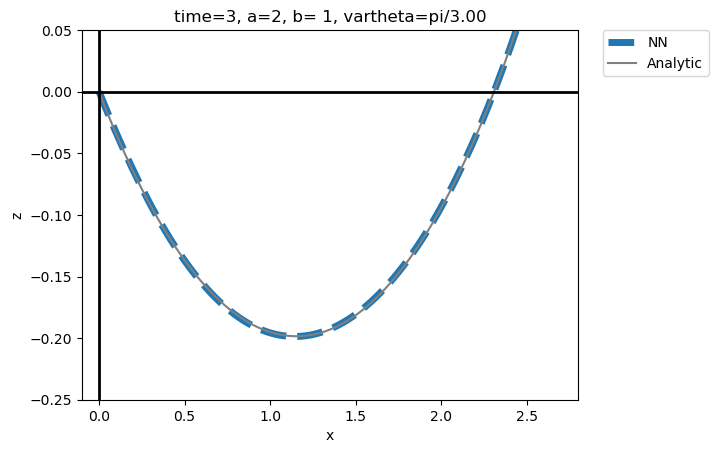

In [25]:
result_outputs = model(training_time_tensor.view(-1, 1))

result_outputs_df = pd.DataFrame(result_outputs.detach().numpy())
result_outputs_df.columns = ['x', 'z', 'p_x', 'p_z']
result_outputs_df["t"] = training_time

   
result_outputs_df["z"] = result_outputs_df["z"] * -1
result_outputs_df["slope"] = result_outputs_df["x"] / result_outputs_df["z"]


result_outputs_df.to_excel("result_outputs_df.xlsx")

true_solution_df = analytic_solution(a, b, vartheta, dt, t_max)

 
plt.plot(result_outputs_df["x"],  result_outputs_df["z"], label = "NN",  linewidth=5, c = "tab:blue", linestyle='dashed')
plt.plot(true_solution_df["x"], true_solution_df["z"] * - 1, label = "Analytic", c = "grey")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(f"time={t_max}, a={a}, b= {b}, vartheta=pi/{np.pi/vartheta:.2f}")
plt.axvline(x=0, color='black', linestyle='-', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(-0.1, 2.8)
plt.ylim(-0.25, 0.05)
plt.show()

Final loss: 0.02442198246717453


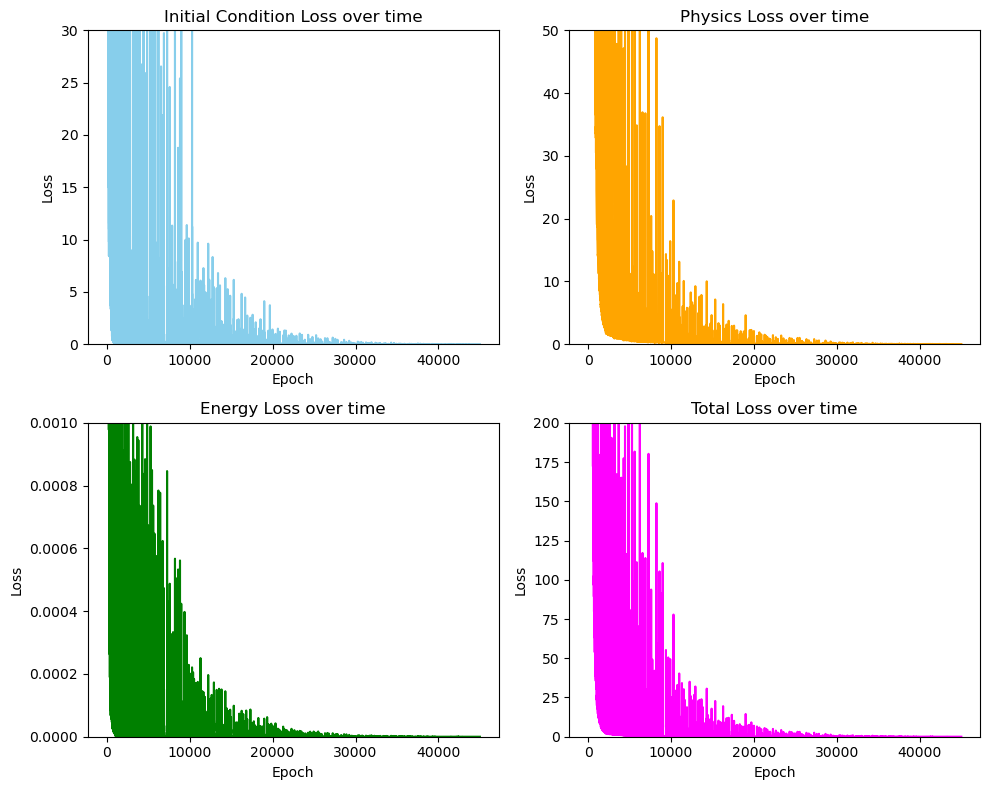

In [7]:
print('Final loss:', total_loss.item())

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(losses_IC, label='Initial Condition Loss ', color='skyblue')
axs[0, 0].set_title('Initial Condition Loss over time')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 30)

axs[0, 1].plot(losses_physics, label='Hamiltonian Loss', color='orange')
axs[0, 1].set_title('Physics Loss over time')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_ylim(0, 50)

axs[1, 0].plot(losses_energy, label='Energy Loss', color='green')
axs[1, 0].set_title('Energy Loss over time')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_ylim(0, 1e-3)

axs[1, 1].plot(losses_total, label='Total Loss', color='magenta')
axs[1, 1].set_title('Total Loss over time')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_ylim(0, 200)

plt.tight_layout()
plt.show()


In [8]:
print(len(training_time_tensor))

401
